In [1]:
import librosa
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import librosa.display as ld
import os

### Creating Feed Model Feed Data:

Let's go ahead and look at the data we are working with. I want to develop a sense of it's structure so I can decide on best method for feeding it into a neural network.

In [2]:
filename = './data/English/english/Abbot_Augustus_Low/audio.ogg'
data, samplerate = sf.read(filename, dtype='float32')

data = data[:, 1]

In [3]:
len(data)

11143168

In [4]:
samplerate

44100

### Observations:

This datafile is very long and it has a high sample rate. In audio data the sample rate refers to Hz which means we have 44100 values per second of audio. 

Let's look at the first 15 seconds using matplotlib.

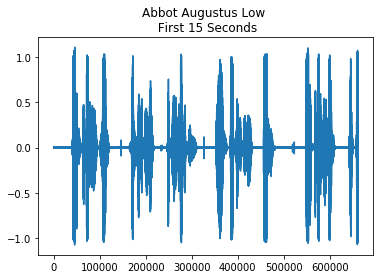

In [5]:
plt.plot(data[0:15*44100])
plt.title('Abbot Augustus Low \n First 15 Seconds');

### Continuing:

It's easy to tell where the words (or sounds maybe) are. But they seem to basically be lines. Let's get a better visual representation.

We'll look at it using librosa:

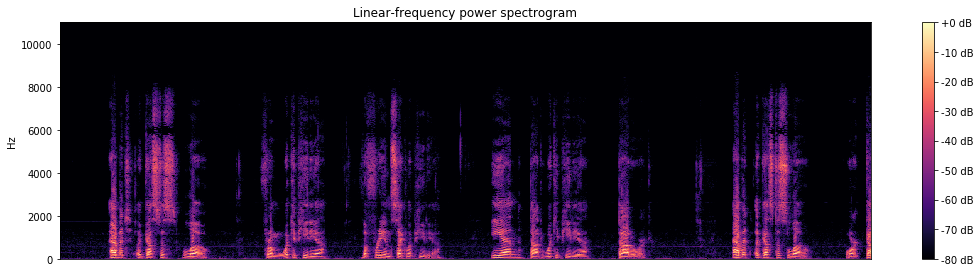

In [6]:
filename = './data/English/english/Abbot_Augustus_Low/audio.ogg'
data, samplerate = sf.read(filename, dtype='float32')


data = data[:, 1]
data = data[0:15*44100].T
data = np.asfortranarray(data)



D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
plt.figure(figsize=(40, 20))
plt.subplot(4, 2, 1)
ld.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram');

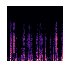

In [7]:
fig = plt.figure(figsize=[1,1])

ax = fig.add_subplot(111)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
ld.specshow(D, y_axis='linear')

plt.savefig('./img_test.jpg', dpi=500, bbox_inches='tight',pad_inches=0)

#### Viewing the image:

<img src='./img_test.jpg' alt='img'>

### Continuing:

So a couple different things are happening here. 

Librosa has a couple issues with the original data. I didn't go over it above but, the first ```[:, 1]``` indexing is converting the stereo data into mono. There are two channels one for left and one for right. I just picked '1' arbitrarily the other option would have been 0. 

It's worth noting that not all of the audio files are stereo which means I'll need to write a function that takes this into consideration. 

After that I needed to Transpose the data. (Turn it sideways) in order for the librosa library to recognize the data. 

It also specifically wants the data in a fortran array. Which are arrays that have some fixed parameters. I won't go into it specifically since it has to do a lot with memory allocation and I'm not particularly familiar with the subject.

After all of that; we can pass the data and sample rate into some librosa functions to generate a spectrogram.

In this image the X dimension represents time and the Y dimension represents frequency. While the values at those points (represented by color) display the intensity of the sound. 

This data style is much easier for the computer to learn from and will also occupy less space in memory when working. 

## Put it in a function:

We're going to be using the dataframe we generated in the previous notebook to populate the information we need for this function to work:

In [8]:
def make_jpg(data, path, title, new_file_name):

    fig = plt.figure(figsize=[1,1])

    ax = fig.add_subplot(111)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    ld.specshow(D, y_axis='linear')
    try:
        os.makedirs(f'data/audio_images/{path}/{title}/')
    except:
        pass
    plt.savefig(f'data/audio_images/{path}/{title}/{new_file_name}', dpi=500, bbox_inches='tight',pad_inches=0)

    plt.close()
    
    del D, fig
    
def generate_data(language, title, file):
    
    # Generate Path:
    
    if language == 1:
        path = 'English/english'
    else:
        path = 'German/german'
    
    # Read in File:
    try:
        filename = f'./data/{path}/{title}/{file}'
        data, samplerate = sf.read(filename, dtype='float32')
        sf.close()
    except:
        pass
    # Check for stereo data:

    try:
        data = data[:, 1]
    except:
        pass
    return data, samplerate, path
    
    
    
def generate_time_slice(sec, data1, samplerate):
    
    
    # Create time segment:    

    data2 = data1[(sec*15)*samplerate : ((sec+1)*15)*samplerate]
    
    data2 = np.asfortranarray(data2)

    return data2

        ### Create Image:

def generate_path(file, sec):

    # Create Image name:

    if file.endswith('o.ogg'):
        marker = 0

    elif file.endswith('1.ogg'):
        marker = 1

    else:
        marker = 2

    new_file_name = f'{marker}_{sec*15}-{sec*15 + 15}_audio_to_img.jpg'

    return new_file_name


In [9]:
df = pd.read_csv('./data/file_dictionary.csv')

In [10]:
df.head()

,Filename,Language,Title
0,audio.ogg,1,Longest_word_in_English
1,audio2.ogg,1,Equal_Protection_Clause
2,audio.ogg,1,Radha
3,audio.ogg,1,Thalassery
4,audio.ogg,1,Lev_Landau


In [11]:
filename, language, title = df.loc[0,:]

In [12]:
data, samplerate, path = generate_data(language, title, filename)

In [13]:
data = generate_time_slice(0, data, samplerate)

In [14]:
new_file_name = generate_path(filename, 0)

In [15]:
make_jpg(data, path, title, new_file_name)

Check that it does what I want by verifying the path: ```'./data/English/english/Longest_word_in_English/0_0-15_audio_to_img.jpg'```

<img src='./data/English/english/Longest_word_in_English/0_0-15_audio_to_img.jpg' alt='Test'>

Our files seem to save exactly as we want:

So lets iterate through the DataFrame and make sure we don't run into any bugs:

### Reading Files is slow:

My original plan was to pass this function into a for loop that iterated through ~20 time intervals. It would run about 7 files and crash. So Instead I created ```1.3_looper.py``` and ```./data/looper.yaml``` 

This file automatically updates the yaml file on each load. I tried using cron to schedule it to run every 5 minutes. However it didn't work properly so I am launching it every few minutes from terminal. Which is mus